In [63]:
import numpy as np 
import cmath
import pandas as pd
import matplotlib.pyplot as plt 

import re
import nltk

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 


### Load Data and EDA

train中有4列，phraseid和sentenceid无意义，可以舍弃

test中仅3列，无sentiment，需要我们自己预测

无需特殊处理数据清洗后产生的的None或者空列表，他们原本都是无意义的停止词，一律按照neutral(中性)处理

标签有如下几种
  + 0 - negative
  + 1 - somewhat negative
  + 2 - neutral
  + 3 - somewhat positive
  + 4 - positive

要求中提到要使用BOW(short of bag of word)和N-gram进行文本表示，但是N-gram在N=1时本身就是BOW，所以只要写一个可以调节N的N-gram tokenization即可。

N-gram文本表示：思路与词袋模型相同，不考虑词的顺序，将N个词作为一组放进词袋里，当N=1时实际上就是BOW。这种方法形成的词向量的长度为字典的长度，每个值都是当前位置代表的词组出现的次数。使用可以过滤一部分低频率的词组来降低字典维度。

In [64]:

train=pd.read_csv("train.tsv", delimiter="\t").drop(columns=["PhraseId","SentenceId"])
test=pd.read_csv("test.tsv", delimiter="\t").drop(columns=["PhraseId","SentenceId"])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Phrase     156060 non-null  object
 1   Sentiment  156060 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [65]:
test.head()

,Phrase
0,An intermittently pleasing but mostly routine ...
1,An intermittently pleasing but mostly routine ...
2,An
3,intermittently pleasing but mostly routine effort
4,intermittently pleasing but mostly routine


In [66]:
train.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [67]:
train["Phrase"]

0         A series of escapades demonstrating the adage ...
1         A series of escapades demonstrating the adage ...
2                                                  A series
3                                                         A
4                                                    series
                                ...                        
156055                                            Hearst 's
156056                            forced avuncular chortles
156057                                   avuncular chortles
156058                                            avuncular
156059                                             chortles
Name: Phrase, Length: 156060, dtype: object

### Tokenization\Dictionary\Vectorization\Feature selection

根据zipf定律，大部分的词汇出现的频率很少，所以将这些词汇根据出现频率删除，由此来进行特征选择。

In [68]:
# 参考代码，refer to https://thinkingneuron.com/how-to-generate-n-grams-in-python/
# # Creating a function to generate N-Grams
# def generate_ngrams(text, WordsToCombine):
#      words = text.split()
#      output = []  
#      for i in range(len(words)- WordsToCombine+1):
#          output.append(words[i:i+WordsToCombine])
#      return output
 
# # Calling the function
# generate_ngrams(text='this is a very good book to study', WordsToCombine=3)

In [69]:
from nltk.corpus import stopwords

def tokenization_to_ngram(sentence,n=1):
    '''
    将句子转化为token,去除停止词,并返回用于n-gram语言建模的特征
    '''
    
    stop_words = set(stopwords.words('english'))
    # print(type(sentence))
    words = re.sub("[^\w]", " ",  sentence).split() 
    filtered_sentence=[w.lower() for w in words if not w in stop_words]
    output=[]
    if(n!=1):
        if(len(filtered_sentence)<n):
            # 对于n>len(filtered_sentence)的情况，直接将句子中所有的词拼接
            tmp=''
            for i in range(len(filtered_sentence)):
                tmp=tmp+filtered_sentence[i]
            output.append(tmp)
            return output
        else:
            # 对于其他情况，将句子分解为n个词一份
            for i in range(len(filtered_sentence)-n+1):
                # 这一步是将n个单词拼在一起作为一个单词，这样的话可以视作一个单词，方便一会儿进行哈希
                tmp=filtered_sentence[i]
                for t in range(1,n):
                    tmp+=filtered_sentence[i+t]
                output.append(tmp)
            return output
    else:
        return filtered_sentence

tokenization_to_ngram(train["Phrase"][7],2)

['escapadesdemonstrating', 'demonstratingadage', 'adagegood', 'goodgoose']

In [70]:
def dictionarymake(df,colums,lim=10):
    '''制作字典'''
    corpus=[]
    for ls in df[colums]:
        for w in ls:
            if( w not in corpus):
                corpus.append(w)
    # 特征选择，根据出现频率决定是否加入字典
    length=len(corpus)
    tmp=np.zeros(length)
    for ls in df[colums]:
        for w in ls:
            tmp[corpus.index(w)]+=1
    dictionary={}
    t=0
    for i,word in enumerate(corpus):
        if(tmp[i]>lim):
            dictionary[word]=t
            t+=1
            
    return dictionary,t

In [71]:
def vectorize(ls,dict,vector_len):
    '''将句子根据字典转化为定长向量'''
    # 使用16位浮点数，防止太长爆掉
    vec=np.zeros(vector_len)
    key=list(dict.keys())
    for w in ls:
        if(w in key):
            vec[dict[w]]+=1
    return vec

### softmax

Logstic回归是softmax在2分类下的特殊情况，所以我们仅实现softmxa。

由于是分类任务，损失函数使用交叉熵。

使用随机梯度下降进行优化，尽管softmax有闭式解，但是这里的矩阵太大，最好使用梯度下降的方法优化。

对于softmax/logistics回归来说，假设$c_k$表示类别k，X表示输入，$W_i$表示每个类别对应的权重，则其公式如下所示：

$P(C=c_k |x=X)=softmax(X)=\frac{e^{W_{k}^TX}}{\sum_{i=1}^{K}{e^{W_{i}^TX}}}$

对于Logistics回归，另一种更严谨的公式是这样的（注意分母没有第K类,此时的公式由两两分类下的对数线性回归严格的推出）：

 + 对于第K类$P(C=c_K |x=X)=logistics(X)=\frac{1}{1+\sum_{i=1}^{K-1}{e^{W_{i}^TX}}}$
 + 对于其余的K-1类，$P(C=c_{k-1} |x=X)=logistics(X)=\frac{e^{W_{k-1}^TX}}{1+\sum_{i=1}^{K-1}{e^{W_{i}^TX}}}$

这是由于下面的两个公式没有同时在分子和分母上乘以$e^{W_{k}^TX}$，由于分子分母同时变大，所以对最终的拟合结果并无影响。同时，上面的式子要对**K**个类别计算参数W，而下面的式子每次分类时需要对**K-1**个参数进行计算。

虽然如此，这并不是说下面的这个式子计算的参数量要少，两者其实计算的参数量是一致的。问题就在于如果采用了下面的这个式子进行计算，我们需要对每个类别计算K-1个参数，每两个类之间的参数一定有K-2个重合，同时每个类都保留一个自己独特的参数。这样两两对比K次，我们就得到了我们所需要的K个独特的参数，这个参数量和上面的式子保持一致。

可以看到上面的这个公式由于更加通用，更加的便于计算，所以更加常见，但是正式的logistics回归其实是下面的这种形式。

**最后需要注意的一点是**，将K个类别完全分开，我们至少需要K个超平面，因此softmax回归等线性分类方法其本质是一种一对其余的分类思想。所以若进行K分类，其权重w最好为(m,k)，也就是对每个类都有一个单独的权重$w_i$将其与其他类分开，因此我们需要将(n,1)的标签y扩展到(n,k)的编码器labelencoder。

参考链接：https://esl.hohoweiya.xyz/04-Linear-Methods-for-Classification/4.4-Logistic-Regression/index.html#_1


In [142]:
from sklearn.model_selection import KFold, RepeatedStratifiedKFold

from numpy.random import shuffle

# 使用softmax进行分类
class softmax():
    def __init__(self,a=0.1,batchsize=64,iteration=1) -> None:
        '''
        X->(n,m):n个m维样例 
        y->(n,k):n个样例,每个样例中有K个值,对应K个类别
        w->(m,k):将x映射到k个类别中
        a:学习率
        iteration:迭代次数
        batchsize:单个batch的大小
        '''
        self.w=None
        self.a=a
        self.batchsize=batchsize
        self.iter=iteration
        self.loss=[]

    def softmax_fun(self,X):
        tmp=X@self.w
        # 防止指数计算得到的结果过大
        tmp-=np.max(tmp,axis=1,keepdims=True)
        k=np.exp(tmp)/np.sum(np.exp(tmp),axis=1,keepdims=True)
        return k


    def labelencoder(self,y,k):
        '''
        将输入的标签根据类别数编码为特定的形状
        '''
        pass

    def labeldecoder(self,y,k):
        '''将输入的K维标签映射回1维'''
        pass

    def loss_fun(self,y,y_hat):
        epsilon = 1e-10  # 添加一个小的值以避免除以零
        loss = -(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
        return np.mean(loss)


    def fit(self,X,y):
        '''根据要求使用mini-batch的梯度下降进行优化'''
        n,m=X.shape
        _,k=y.shape
        # 将X增广一列，以训练bias
        X_aug=np.concatenate((X,np.ones((n,1))),axis=1)
        self.w=np.random.randn(m+1,k)
        # mini-batch SGD
        batch=len(X_aug)//self.batchsize
        for it in range(self.iter):
            # 每轮训练开始时，打乱数据集
            shuffle_index=np.random.permutation(len(X_aug))
            X_=X_aug[shuffle_index]
            y_=y[shuffle_index]    
            for i in range(batch):
                # 注意越界
                if(i!=batch-1):
                    begin=i*self.batchsize
                    end=(i+1)*self.batchsize
                else:
                    # 最后一个batch，单独处理防止越界
                    begin=i*self.batchsize
                    end=len(X_aug)
                batch_x=X_[begin:end]
                batch_y=y_[begin:end]
                # SGD
                y_hat=self.softmax_fun(batch_x)
                # 记录loss
                loss=self.loss_fun(batch_y,y_hat)
                self.loss.append(loss)
                self.w+=self.a*batch_x.T@(batch_y-y_hat)/self.batchsize

    def predict(self,X):
        # 增广一列，加入bias
        a,_=X.shape
        X_aug=np.concatenate((X,np.ones((a,1))),axis=1)
        return self.softmax_fun(X_aug)

### BOW

In [144]:
# 将所有短语提取出来
all_phrase_1=pd.concat([train["Phrase"],test["Phrase"]],axis=0,ignore_index=True)\
            .apply(tokenization_to_ngram,n=1)\
            .to_frame()


In [145]:
# 将训练集上的短语提取出来
X_train_1=train["Phrase"].apply(tokenization_to_ngram,n=1).to_frame()
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Phrase  156060 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [146]:
# 制作对应的字典
dict_1,len_v1=dictionarymake(all_phrase_1,colums="Phrase",lim=30)
len_v1

5268

In [147]:
# 将数据转化为numpy数组的格式
X1=X_train_1["Phrase"]\
    .apply(vectorize,dict=dict_1,vector_len=len_v1)\
    .to_numpy()
y=train["Sentiment"].to_numpy()

In [148]:
X1=np.stack(X1,axis=0)
y=y.reshape(y.shape[0],1)
# 划分测试集和验证集,验证集不需要太大
val_size=0.1
train_size=int(len(X1)*(1-val_size))
X_train_1,y_train_1=X1[:train_size],y[:train_size]
X_val_1,y_val_1=X1[train_size:],y[train_size:]

In [173]:
# 计算准确度
def acc(y_hat,y):
    return np.mean(y==y_hat)

In [150]:

soft=softmax(a=1e-6,iteration=10)
soft.fit(X_train_1,y_train_1)
y_pred_1=soft.predict(X_val_1)
print(acc(y_pred_1,y_val_1))

[0.20017942]


Text(0.5, 1.0, 'Loss Curve')

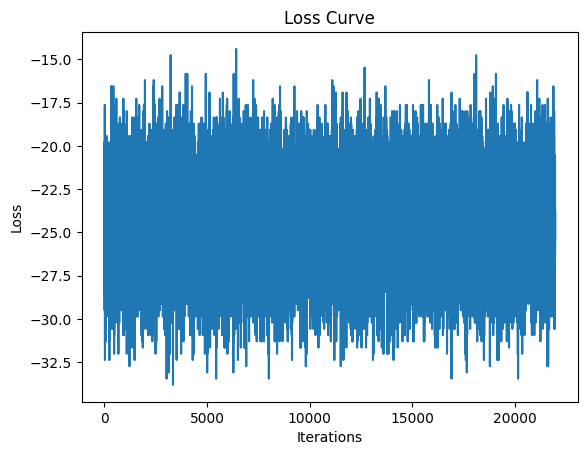

In [151]:
plt.plot(soft.loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')

In [159]:
# from sklearn.linear_model import LogisticRegression

# ls=LogisticRegression()
# ls.fit(X_train_1,y_train_1)
# n=ls.predict(X_val_1)
# print(acc(y=y_val_1,y_hat=n))

[0.48801743 0.48801743 0.48801743 ... 0.48801743 0.48801743 0.48801743]


In [201]:
# n[:100]
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

# a,b=make_classification(n_samples=1000,n_features=50,n_informative=4,n_clusters_per_class=2,n_classes=2)
# b=b.reshape(1000,1)
# X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.2, random_state=42)
# model=softmax(a=1e-3,iteration=5000)
# model.fit(X_train,y_train)
# m=model.predict(X_test)
# ls.fit(X_train,y_train)
# m=ls.predict(X_test)
# print(acc(y_test,m))
# softmax不收敛，代码有问题

0.5


In [152]:
# del X1
# del dict_1
# del X_train_1,y_train_1
# del X_val_1,y_val_1
# del all_phrase_1
# del y_pred_1

### N-gram

In [153]:

# all_phrase_2=pd.concat([train["Phrase"],test["Phrase"]],axis=0,ignore_index=True)\
#             .apply(tokenization_to_ngram,n=2)\
#             .to_frame()
# X_train_2=pd.DataFrame(train["Phrase"],columns=["newphrase"]).apply(tokenization_to_ngram,n=2)

In [154]:
# dict_2,len_v2=dictionarymake(all_phrase_2,colums="newphrase")
# dict_2,len_v2=feature_selection(dict_2,len_v2,all_phrase_2,columns="allphrase")

In [155]:
# X2=X_train_2["newphrase"].apply(vectorize,dict=dict_2,vector_len=len_v2)
# X2.head()

In [156]:
# 将数据打乱
# shuffle_index=np.random.permutation(len(X_aug))
# X_=X_aug[shuffle_index]
# y_=y[shuffle_index]
        
# 划分测试集和验证集,验证集不需要太大
# train_size=int(len(X_aug)*(1-self.eva))
# X_train,y_train=X_[:,:train_size],y_[:,:train_size]
# X_eval,y_eval=X_[:,train_size:],y_[:,train_size:]
        

In [157]:
# del X2
# del dict_2
# del X_train_2
# del all_phrase_2